In [104]:
from collections import defaultdict

import networkx as nx

"""
00 01 02 03 04 05 06 07 08 09 10
      11    12    13    14
      15    16    17    18
      19    20    21    22
      23    24    25    26
"""

IGNORE = frozenset({'#', '\n', ' '})
AMPHIPODS = frozenset('ABCD')
DIAGFMT = ''.join('{}' if c == '.' else c for  p, c in enumerate('#############\n#...........#\n###.#.#.#.###\n  #.#.#.#.#\n  #########'))
EDGES = (0, 1), (1, 2), (2, 3), (2, 11), (11, 15), (3, 4), (4, 5), (4, 12), (12, 16), (5, 6), (6, 7), (6, 13), (13, 17), (7, 8), (8, 9), (8, 14), (14, 18), (9, 10), (15, 19), (19, 23), (16, 20), (20, 24), (17, 21), (21, 25), (18, 22), (22, 26) 
FORBIDDEN = frozenset({2, 4, 6, 8})
HALLWAY = frozenset({0, 1, 3, 5, 7, 9, 10})
HOME = {
  'A': frozenset({11, 15, 19, 23}),
  'B': frozenset({12, 16, 20, 24}),
  'C': frozenset({13, 17, 21, 25}),
  'D': frozenset({14, 18, 22, 26}),
}
COST = dict(zip('ABCD', (1, 10, 100, 1000)))

def diag2pos(diag):
  a2n = defaultdict(int)
  pos = dict()
  for p, c in enumerate(c for c in diag if c not in IGNORE):
    if c in AMPHIPODS:
      n = a2n[c]
      a2n[c] += 1
      pos[f'{c}{n}'] = p
  return tuple(pos.items())

def pos2diag(pos):
  arr = ['.'] * 19 
  for a, p in pos: arr[p] = a[0]
  return DIAGFMT.format(*arr)

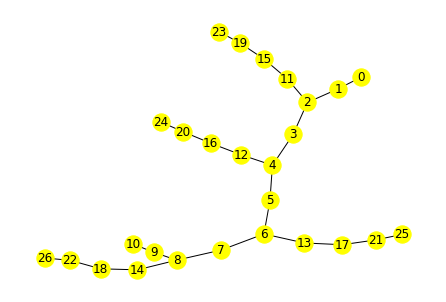

In [105]:
GRAPH = nx.from_edgelist(EDGES)
nx.drawing.draw(GRAPH, with_labels = True, node_color = 'yellow')
PATHS = {frm: {to: frozenset(path[1:]) for to, path in paths.items() if to not in {frm} | FORBIDDEN} for frm, paths in nx.all_pairs_shortest_path(GRAPH)}

In [106]:
from functools import lru_cache 

@lru_cache(maxsize = None)
def next_steps(pos):
  
  pos = dict(pos)
  sop = {v: k for k, v in pos.items()}
  occupied = frozenset(pos.values())
  res = []

  def _next(amp):

    a, n = amp
    start = pos[amp]

    at_home = set(sop[p][0] for p in HOME[a] if p in sop)
    if start in HALLWAY:
      if at_home <= {a}:
        allowed = HOME[a] - occupied
        if allowed: allowed = {max(allowed)}
      else:
        allowed = set()
    else:
      if at_home <= {a} and start in HOME[a]:
        allowed = set()
      else:
        allowed = HALLWAY
    
    for to, path in PATHS[start].items():
      if to in allowed and not path & occupied:
        res.append((COST[a] * len(path), amp, to))

  for amp in pos: _next(amp)
  return res

In [109]:
diag ="""
#############
#...........#
###B#C#B#D###
  #D#C#B#A#
  #D#B#A#C#
  #A#D#C#A#
  #########
"""

diag = """
#############
#...........#
###D#C#B#C###
  #D#C#B#A#
  #D#B#A#C#
  #D#A#A#B#
  #########
"""

In [102]:
MAX_COST = float('inf')

def visit(pos, tot_cost):
  global MAX_COST
  if tot_cost > MAX_COST: return
  ns = next_steps(pos)
  if not (ns or any(p in HALLWAY for _, p in pos)):
    if MAX_COST > tot_cost: 
      MAX_COST = tot_cost
      print(tot_cost)
  ns = sorted(ns)
  for cost, amp, np in ns:
    next_pos = dict(pos)
    next_pos[amp] = np
    visit(tuple(next_pos.items()), cost + tot_cost)

pos = diag2pos(diag)
visit(pos, 0)

16741
14741
14541
12541
12539
12521


In [62]:
def clean(Q):
  q0 = len(Q)
  Qp = [(c, p) for c, p in Q if -c < MAX_COST]
  qp = len(Qp)
  if qp - q0 > 0: print('removed', qp - q0)
  #heapify(Qp)
  return Qp

In [111]:
from heapq import *

MAX_COST = float('inf')

Q = [(0, diag2pos(diag))]
while Q:
  tot_cost, pos = Q.pop()
  tot_cost *= -1
  ns = next_steps(pos)
  if not (ns or any(p in HALLWAY for _, p in pos)):
    if MAX_COST > tot_cost: 
      MAX_COST = tot_cost
      #Q = clean(Q)
      print(tot_cost, len(Q))
  for cost, amp, np in ns:
    next_pos = dict(pos)
    next_pos[amp] = np
    if tot_cost+ cost < MAX_COST:
      Q.append((-(tot_cost+ cost), tuple(next_pos.items())))


48741 139
48543 138
48541 139


KeyboardInterrupt: 